# ДЗ к Уроку 1. Обработка изображений и компьютерное зрение.

Напишите на Python реализацию как минимум одного алгоритма на выбор: любая на выбор цветовая обработка, перевод в другое цветовое пространство или фильтрация. Изображение выберите самостоятельно.

### Подготовка

mode:1


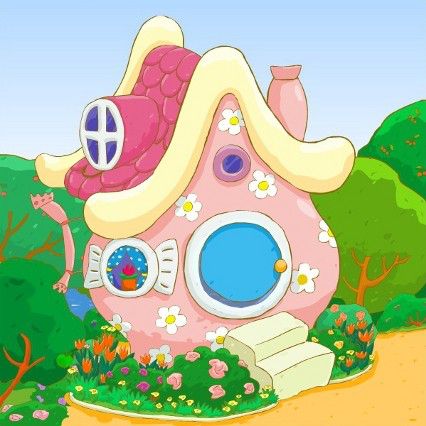

In [12]:
import random
from PIL import Image, ImageDraw #Подключим необходимые библиотеки. 

mode = int(input('mode:')) #Считываем номер преобразования. 
image = Image.open("temp.jpg") #Открываем изображение. 
draw = ImageDraw.Draw(image) #Создаем инструмент для рисования. 
width = image.size[0] #Определяем ширину. 
height = image.size[1] #Определяем высоту. 	
pix = image.load() #Выгружаем значения пикселей.
image

### Оттенки серого

In [ ]:
if (mode == 0):
    for i in range(width):
        for j in range(height):
            a = pix[i, j][0]
            b = pix[i, j][1]
            c = pix[i, j][2]
            S = (a + b + c) // 3
            draw.point((i, j), (S, S, S))
    image.save("grey.jpg", "JPEG")

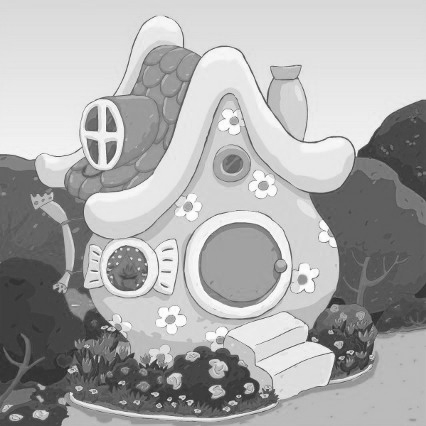

In [8]:
image

### Сепия

In [13]:
if (mode == 1):
    depth = int(input('depth:'))
    for i in range(width):
        for j in range(height):
            a = pix[i, j][0]
            b = pix[i, j][1]
            c = pix[i, j][2]
            S = (a + b + c) // 3
            a = S + depth * 2
            b = S + depth
            c = S
            if (a > 255):
                a = 255
            if (b > 255):
                b = 255
            if (c > 255):
                c = 255
            draw.point((i, j), (a, b, c))
    image.save("sepia.jpg", "JPEG")

depth:10


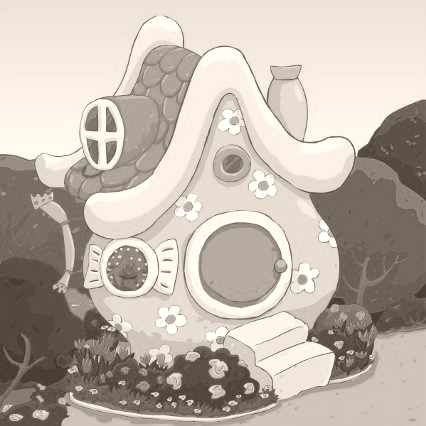

In [14]:
image

In [15]:
del draw